## Fukuro Adaptive Monte Carlo Localization

### A. Importing Dependencies 

In [1]:
# DEPENDENCIES
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [2]:
# AMCLL PARAMETERS
NUM_PARTICLES = 100
MAP_SIZE = (100, 100)

# ROBOT PARAMETERS
MOVE_DISTANCE = 5.0
NOISE_STD = 2.0
robot_position = np.array([20.0, 20.0])

In [3]:
class Particle:
    def __init__(self, x, y, weight=1.0):
        self.x = x
        self.y = y
        self.weight = weight
    def move(self, dx, dy):
        self.x += dx + np.random.normal(0, NOISE_STD) # ONLY FOR SIMULATION
        self.y += dy + np.random.normal(0, NOISE_STD) # ONLY FOR SIMULATION

def particle_generator():
    return [Particle(x=np.random.uniform(0, MAP_SIZE[0]),
                     y=np.random.uniform(0, MAP_SIZE[1]))                    
            for _ in range(NUM_PARTICLES)] # GENERATE N PARTICLES

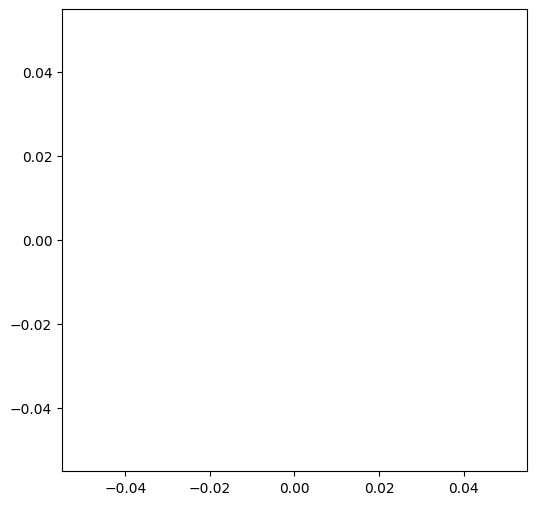

In [4]:
# Visualization canvas
fig, ax = plt.subplots(figsize=(6, 6))
sc_particles = ax.scatter([], [], c='blue', label='Particles')
sc_robot = ax.scatter([], [], c='red', s=100, label='Robot')
step_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def sense(particle, robot_pos): # SELECTING PARTICLES ACCORDING TO EUCLIDIAN DISTANCE AS LIKELIHOOD
    # NORMALIZE DISTANCE
    distance = np.linalg.norm(np.array([particle.x, particle.y]) - robot_pos) 

    # CALCULATING HOW LIKELY THE PARTICLE IS CLOSE WITH TRUE POSITION 
    # THIS CALCULATION USE GAUSSIAN OR NORM DIST PDF FUNCTION
    # SO IT DEPENDS ON THE NOISE STD VALUE 
    return np.exp(-distance**2 / (2 * NOISE_STD**2))

def resample(particles): # PARTICLE WEIGHT BASED RESAMPLING
    weights = np.array([p.weight for p in particles])
    weights += 1e-300 # ADDING EXTREMELY SMALL VALUE TO PREVENT DIVISION BY ZERO
    weights /= np.sum(weights) # NORMALIZE THE WEIGHTS
    indices = np.random.choice(len(particles), size=len(particles), p=weights)
    return [Particle(particles[i].x, particles[i].y) for i in indices]

In [5]:
# Simulation step manager
state = ['predict', 'sense', 'resample', 'move']
step_counter = 0

def update(frame):
    global particles, robot_position, step_counter
    ax.clear()
    ax.set_xlim(0, MAP_SIZE[0])
    ax.set_ylim(0, MAP_SIZE[1])

    current_step = state[step_counter % len(state)]

    if current_step == 'predict':
        # 1. Prediction step: simulate motion
        for p in particles:
            p.move(MOVE_DISTANCE, 0)
        step_text.set_text("Step: Prediction")
        ax.set_title("1. Prediction: Motion update")
        color = 'gray'

    elif current_step == 'sense':
        # 2. Weight update based on sensing
        for p in particles:
            p.weight = sense(p, robot_position)
        step_text.set_text("Step: Sensing / Weighting")
        ax.set_title("2. Sensing: Weight Update")
        color = 'blue'

    elif current_step == 'resample':
        # 3. Resample based on weights
        particles = resample(particles)
        step_text.set_text("Step: Resampling")
        ax.set_title("3. Resampling: Particle Selection")
        color = 'green'

    elif current_step == 'move':
        # 4. Robot moves
        robot_position[0] += MOVE_DISTANCE
        step_text.set_text("Step: Robot Moving")
        ax.set_title("4. Robot Moves")
        color = 'red'

    step_counter += 1

    # Draw
    xs = [p.x for p in particles]
    ys = [p.y for p in particles]
    ax.scatter(xs, ys, color=color, alpha=0.6, label='Particles')
    ax.scatter(robot_position[0], robot_position[1], color='red', s=100, label='Robot')
    ax.legend()
    ax.text(0.02, 0.95, f"Step: {current_step.upper()}", transform=ax.transAxes)

ani = animation.FuncAnimation(fig, update, frames=100, interval=1000)
plt.show()